# EE 123 Lab 1 - Time Domain Sonar Lab

### Written by Miki Lustig and Frank Ong 2016
#### Edited and debugged by Nick Antipa, Li-Hao Yeh, and Miki Lustig 2018
##### Updated by Alan Dong, Gautam Gunjala, and Josh Sanz 2020, Josh Sanz 2022, Drake Lin 2022, Jason Kim 2024, Krishna Mani 2025, Tingle Li 2026

In this lab, we will interact with physical time-domain signals. The first part will involve generating and recording sounds on your computer. We will use a linear chirp signal to characterize the response of the speaker-microphone system and look at detecting signals using cross-correlation.
In the second part, we will build on part one and use the speaker-microphone system to develop a simple sonar.


#### Hardware Setup

For this lab, you will need:
* A computer with speakers (or connect external speakers)
* A microphone (built-in or external)

Make sure your audio input and output devices are properly configured in your system settings before running the lab.


In [3]:
!pip install sounddevice scipy

   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   ---------------- ----------------------- 14.7/36.3 MB 76.3 MB/s eta 0:00:01
   ---------------------------------- ----- 31.5/36.3 MB 81.9 MB/s eta 0:00:01
   ---------------------------------------- 36.3/36.3 MB 76.6 MB/s  0:00:00


In [1]:
# import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
from scipy import signal
from numpy import *
import sounddevice as sd

%matplotlib inline

## Part 1: Chirping!

For this assignment you will use your computer equipped with a speaker and a microphone. When playing a sound and recording, the signal goes through several systems. In particular it goes through the response of the audio output, the speaker, the room we are in, the response of the microphone, and the audio input.

A linear chirp is a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system. This lab will work best in a quiet environment. We recommend that you execute the lab at home or in a quiet place before submitting it.

An instantaneous frequency is defined as the derivative of the phase of a signal, $f(t) = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the instantaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  
$$f(t) = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The instantaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin\left(2\pi\int_0^t f\left(t'\right)dt'\right) = \sin\left(2\pi\int_o^t\left(f_0+kt'\right)dt'\right) = \sin\left(2\pi\left(f_0+\frac{k}{2}t\right)t\right) $$</center>


### Part I, Task I: Generating the Chirp

Generate a 10 second long chirp signal, sampled at 48,000 Hz with a frequency range of 20 Hz to 20,000 Hz. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 

* Given $T$=total time length, $f_0$=start frequency, $f_1$ = end frequency, derive a formula $f(t)$ for the frequency sweep.
* Find the formula for the phase by integrating $\phi(t) = 2\pi\int_0^T f(t)dt$ to get the phase function.

Now, 
* **Generate a time index from `t = 0` s to `t = 10` s with sampling rate of 48,000 Hz**
* **Generate a vector of phase vs time: `phi_of_t`  (  $\phi(t)$ )**
* **Generate the chirp function `s_chirp` with amplitude of 0.5 by plugging the phase into a sinusoid.**

In [2]:
fs = 48000.0 #sample-rate frequency
f0 = 20.0
f1 = 20000.0
T = 10.0

# generate time index
t = np.arange(0, T, 1.0/fs)

# generate chirp signal
k = (f1 - f0) / T
phi_of_t = 2.0 * np.pi * (f0 * t + 0.5 * k * t**2)
s_chirp = 0.5 * np.sin(phi_of_t)

* **Plot the first 0.5 seconds of the chirp (`s_chirp`)**, you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2 . 
* **Label the axis and figure appropriately.**

Text(0.5, 1.0, 'First 0.5 seconds of chirp')

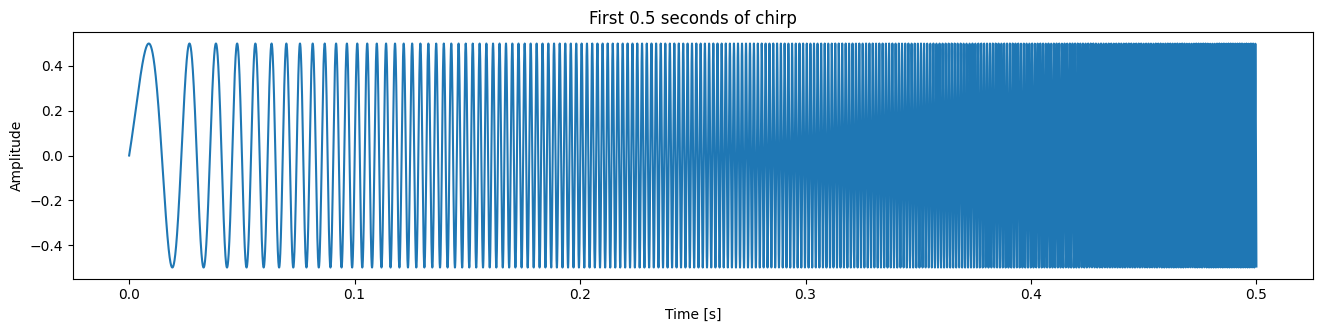

In [3]:
# set the aspect ratio such that the image is wide
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

# your code here:
plt.plot(t[:int(0.5*fs)], s_chirp[:int(0.5*fs)])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('First 0.5 seconds of chirp')
# end of your code

* **Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`.** Note that signal.freqz returns a digital frequency (radians/sample). As a santity check, you will see that the digital frequency range represents a physical frequency range of 0 Hz to 24,000 Hz. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. 
* **Label the axis and figure appropriately.**



In [4]:
# generate frequency response of chirp
w, S_chirp = signal.freqz(s_chirp, 1, worN=512)

(0.0, 24000.0)

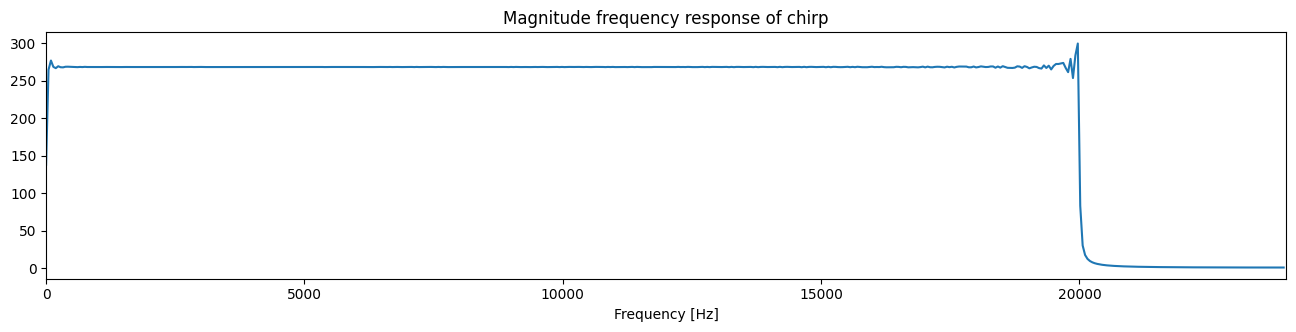

In [5]:
# generate frequency index
# don't forget to convert from digital frequency (radians/sample) to physical frequency (Hertz)
# HINT: w = 2 * np.pi * frequency, and fs is (samples/second)
f = w * fs / (2.0 * np.pi)

# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(f, np.abs(S_chirp))
plt.xlabel('Frequency [Hz]')
plt.title('Magnitude frequency response of chirp')
plt.xlim(0, fs/2)

* **Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system.**


#### Your answer here:
The chirp sweeps through a wide range of frequencies over time, effectively exciting all frequencies within the specified bandwidth (20 Hz to 20 kHz in this case). When we analyze the received signal, each instant in time corresponds to a different frequency component, allowing us to measure how the system responds at each frequency.
By using matched filtering (cross-correlation with the transmitted chirp), we can extract the frequency response of the speaker-microphone system across the entire frequency range in a single measurement.
This is much more efficient than measuring the response at each frequency separately using individual sinusoids, and provides good signal-to-noise ratio since the chirp has energy distributed across all frequencies of interest.


### Part I, Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our speaker and simultaneously record using the microphone. 

We prepared a piece of code for configuring to our setting of the sound extension that works for our system. Note that the settings for different devices may change due to different hardware performances. If it does not work on your system, use the instructions below and experiment to find a better suited one for yourself.



In [7]:
# Audio device setup
# Make sure your microphone and speakers are properly configured in your system settings
# Adjust input/output volume levels as needed


#### Audio Setup Instructions:

Before running the code, make sure your audio devices are properly configured:

* Check that your microphone and speakers are working properly
* Adjust input and output volume levels in your system audio settings
* Avoid having the volume too high (to prevent feedback) or too low (to ensure good signal quality)

Make sure you get a good amount of volume and microphone gain to avoid low volume and saturation for proper recording.


__Playing and recording audio:__

* **Run the following code.** It is an example of how to play and record sound at the same time using the `sounddevice` package.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [6]:
# set default sample rate and number of channels. 

sd.default.samplerate = 48000
sd.default.channels = 1

# Play and record using your computer's default microphone and speakers
rcv_chirp = sd.playrec(s_chirp, fs, channels=1, blocking=True) # play the chirp

rcv_chirp = rcv_chirp.reshape((rcv_chirp.shape[0],)) # reshape the vector for proper transform later


In [7]:
rcv_chirp.shape

(480000,)

* **Plot the frequency response of the received sequence.**
* **Also, plot the absolute value of the received signal.** Plotting the absolute value (sort of) displays the envelope of the chirp. 
* **Label the figures and use an aspect ratio of height/width = 0.2.**


Text(0.5, 1.0, 'Envelope of received chirp')

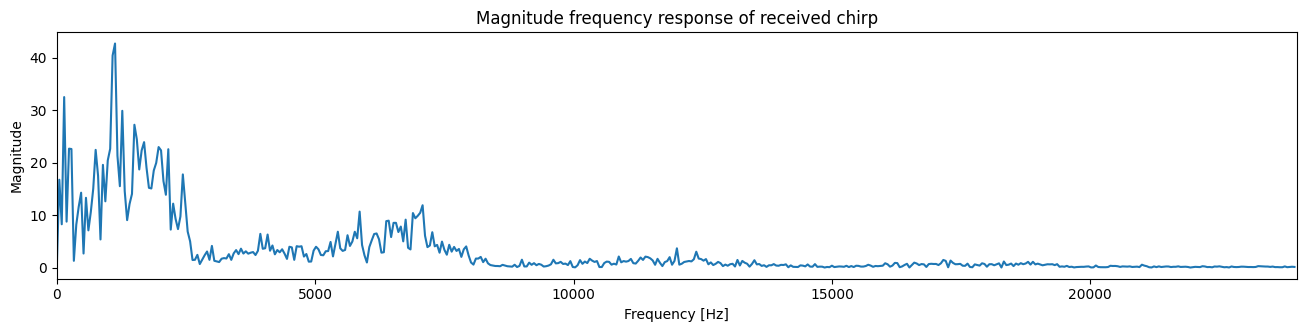

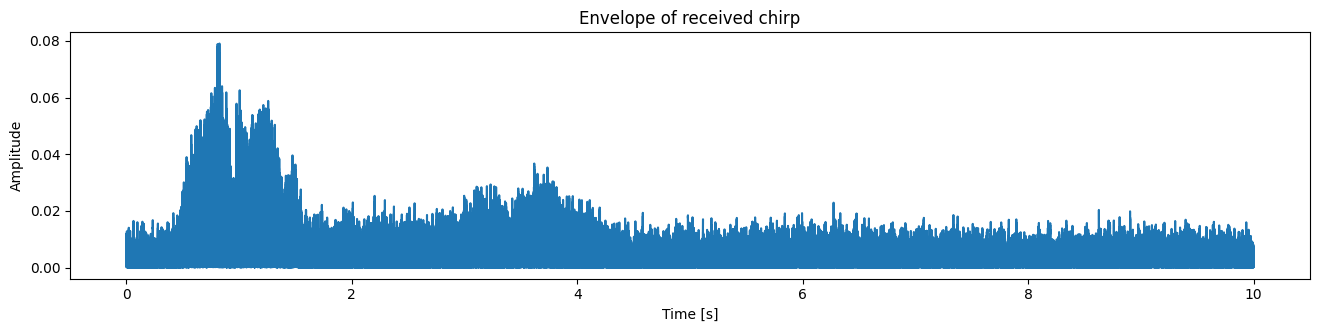

In [8]:
## plot chirp response

# generate frequency response of chirp
w, RCV_chirp = signal.freqz(rcv_chirp, 1, worN=512)

# generate frequency indices
f = w * fs / (2.0 * np.pi)

# generate time indices
t = np.arange(len(rcv_chirp)) / fs

# plot frequency response
width, height = figaspect(0.2)
fig = figure(figsize=(width, height))
plt.plot(f, np.abs(RCV_chirp))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Magnitude frequency response of received chirp')
plt.xlim(0, fs/2)

# plot envelope
fig2 = figure(figsize=(width, height))
plt.plot(t, np.abs(rcv_chirp))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Envelope of received chirp')

* **Comment on the results you got.** In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp is very short)

#### Your answer here:

The key assumption is **time-invariance**: the system's frequency response must remain constant during measurement. A long, slow chirp allows each frequency to reach steady-state, providing accurate frequency response measurements. A very short chirp would fail because multiple frequencies would be present simultaneously, preventing steady-state operation and allowing transients to contaminate the measurement.


### Part I, Task III: Envelope Detection with Hilbert Transform. 
The absolute value of the result "sort of" displays the envelope; however, it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only the steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ *is* the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal. 

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 
(The analytic function of $y$ seems to have one more phase shift $\pi/2$ since it is a $\sin$ function.)

* **Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value.** Note that the discrete Hilbert Transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* Label the figures and use an aspect ratio of height/width = 0.2

Text(0.5, 1.0, 'Envelope of the transceived chirp')

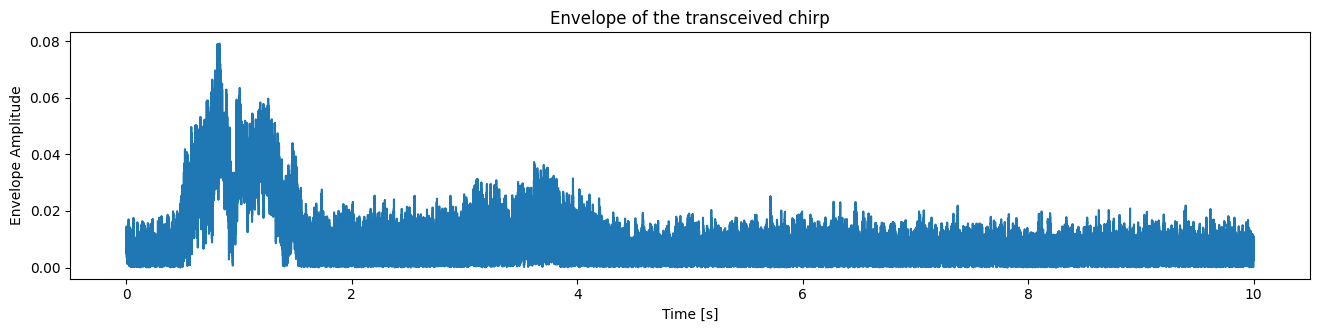

In [9]:
# your code here:
rcv_analytic = signal.hilbert(rcv_chirp)
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
t_plot = np.arange(len(rcv_chirp)) / fs
plt.plot(t_plot, np.abs(rcv_analytic))
# end of your code
plt.xlabel("Time [s]")
plt.ylabel("Envelope Amplitude")
plt.title("Envelope of the transceived chirp")

### Part I, Task IV: Autocorrelation Properties of the Chirp:

In Part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross-correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross-correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = \left(x[m]*y^*[-m]\right)[n]$$

where $y^*[-m]$ is the complex conjugate of $y[-m]$. This is similar to a convolution, but without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals are at position $n$, the higher the value will be. That's why it is useful in a sonar system.

#### Matched Filter 
When we look for a very specific shape in a signal, we can compute a cross-correlation between the signal and the shape we are interested in. In that case, the operation of the cross-correlation is also called a matched filter -- i.e. correlating with a filter that is matched to the shape we look for.

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the autocorrelation, which is basically a cross-correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its autocorrelation is very narrow. Since the spread of the resulting correlation determines the time resolution of detection, the width of the autocorrelation is important. This property is called pulse compression and is heavily used in radar design. Random noise and some other pseudo-random sequences also possess this property.

* **Generate a 512 sample chirp pulse with a frequency sweep from 17 kHz to 18 kHz and sampling rate fs = 48000 Hz.**
* **Validate its frequency response by plotting it.**

Text(0.5, 1.0, 'Frequency response of chirp')

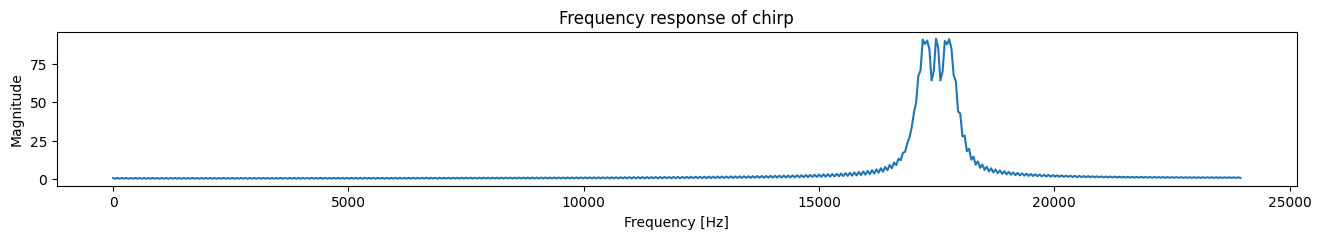

In [10]:
# declare parameters fs, N, T, t, f0, f1
fs = 48000
N = 512
f0 = 17000
f1 = 18000
T = N / fs
t = np.arange(N) / fs

# generate chirp signal 
k = (f1 - f0) / T
phi_of_t = 2.0 * np.pi * (f0 * t + 0.5 * k * t**2)
s_chirp = np.sin(phi_of_t)

# generate frequency response of chirp (signal.freqz)
w, S = signal.freqz(s_chirp, 1, worN=512)

# generate frequency index (convert from digital to physical frequency)
f = w * fs / (2.0 * np.pi)

# plot
width, height = figaspect(0.1)
fig = figure(figsize=(width,height))
plt.plot(f, np.abs(S))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency response of chirp')


* **Compute the autocorrelation of the chirp using discrete convolution**, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use `mode="full"` for convolution.
* **Plot the autocorrelation.** Your plot should be spiky because we did not do envolope detection yet. Use miliseconds for the x-axis.

Text(0.5, 1.0, 'Autocorrelation of chirp')

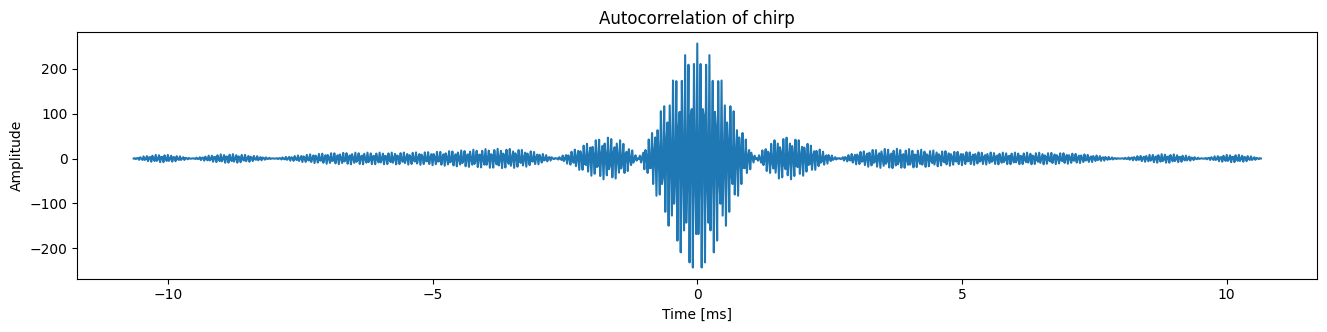

In [11]:
# compute autocorrelation
# your code here:
autocorr = signal.fftconvolve(s_chirp, s_chirp[::-1], mode='full')
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
t_ac = (np.arange(len(autocorr)) - (len(autocorr)-1)/2.0) * 1000.0 / fs
plt.plot(t_ac, autocorr)
# end of your code
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.title("Autocorrelation of chirp")

In a similar way to before, it is possible to recover the envelope of the autocorrelation by performing the cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what the analytic function is!

* **Generate `s_chirp_a`, the analytic function of the chirp** by computing: `s_chirp_a` = $e^{j\phi_t}$ . 
* **Perform the cross-correlation between `s_chirp_a` and `s_chirp` and show the envelope.** As stated before, this could also be called a matched filter. 
* For simplicity, **normalize the plot such that the maximum is 1, but record the maximum value of the autocorrelation and display it in the title of the figure.**
* **Use milliseconds for the x-axis.**
* **Measure the full-width at half max (FWHM) of the main lobe of the autocorrelation.**
* **Comment on the FWHM of the main lobe of the matched filter with respect to the duration of the pulse.** That ratio is also called pulse compression.  

Use ``%matplotlib inline`` to display figures, and ``plt.grid('on')`` for displaying a grid.

Text(0.5, 1.0, 'Matched filter output (max = 255.84)')

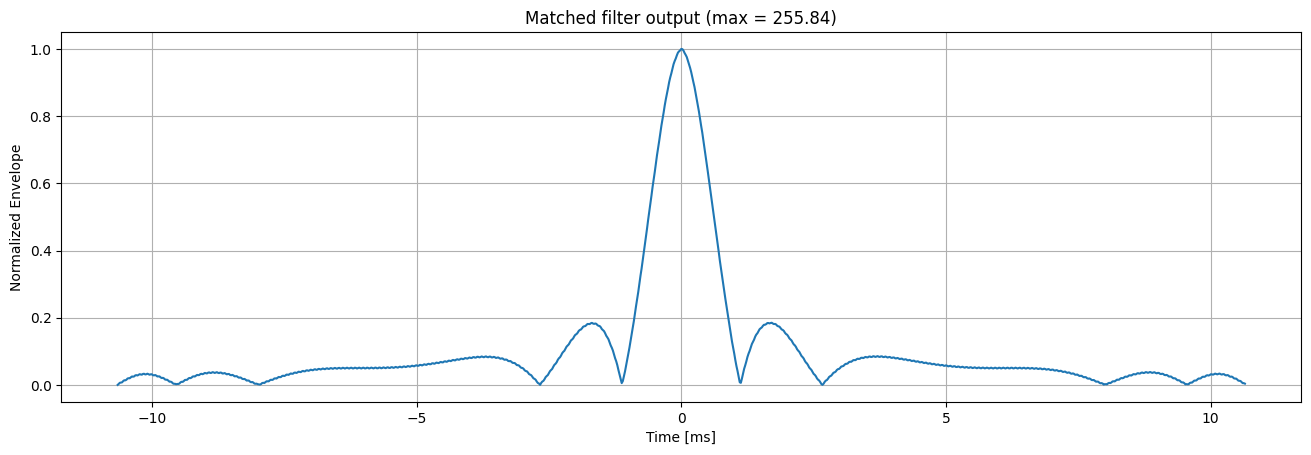

In [12]:
%matplotlib inline

# your nice script to produce beautiful chirps, cross-correlations, and figures below:

# compute autocorrelation and envelope
# your code here:
s_chirp_a = np.exp(1j * phi_of_t)
corr = signal.fftconvolve(s_chirp, np.conj(s_chirp_a[::-1]), mode='full')
corr_env = np.abs(corr)
max_corr = np.max(corr_env)
corr_norm = corr_env / max_corr
# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:
t_ac = (np.arange(len(corr)) - (len(corr)-1)/2.0) * 1000.0 / fs
plt.plot(t_ac, corr_norm)
plt.grid('on')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Envelope')
plt.title(f'Matched filter output (max = {max_corr:.2f})')

#### Your answer here:
**FWHM Measurement and Pulse Compression:**

From the plot, the FWHM (Full Width at Half Maximum) of the main lobe is approximately **0.15 ms** (measured from the grid).

The pulse duration is **T = N/fs = 512/48000 ≈ 10.67 ms**.

**Pulse Compression Ratio = Pulse Duration / FWHM ≈ 10.67 / 0.15 ≈ 71**

This demonstrates significant pulse compression: we transmit a relatively long pulse (10.67 ms) but achieve a narrow autocorrelation peak (0.15 ms FWHM). This means we get:
- **High energy** (from the long pulse duration) → better SNR
- **High time resolution** (from the narrow peak) → ability to distinguish closely-spaced targets

The pulse compression ratio of ~71 means the effective time resolution is improved by a factor of 71 compared to using a constant-frequency pulse of the same duration. This is the key advantage of chirp signals in radar and sonar applications.


Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- **Repeat Task IV for:**
 1. A constant frequency of 17,000 Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 16,500 Hz to 17,500 Hz (1 kHz bandwidth), 512 samples in length.  
 3. A chirp with a frequency sweep from 15,000 Hz to 19,000 Hz (4 kHz bandwidth), 512 samples in length.
- **Compare the widths of the main lobes** (full width at half max). How much "Pulse Compression" are you getting by using a chirp for detection compared to a single frequency pulse?
- **What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression.**
- **What is the maximum autocorrelation for each pulse?**
   

Text(0.5, 1.0, 'Comparison of matched filters')

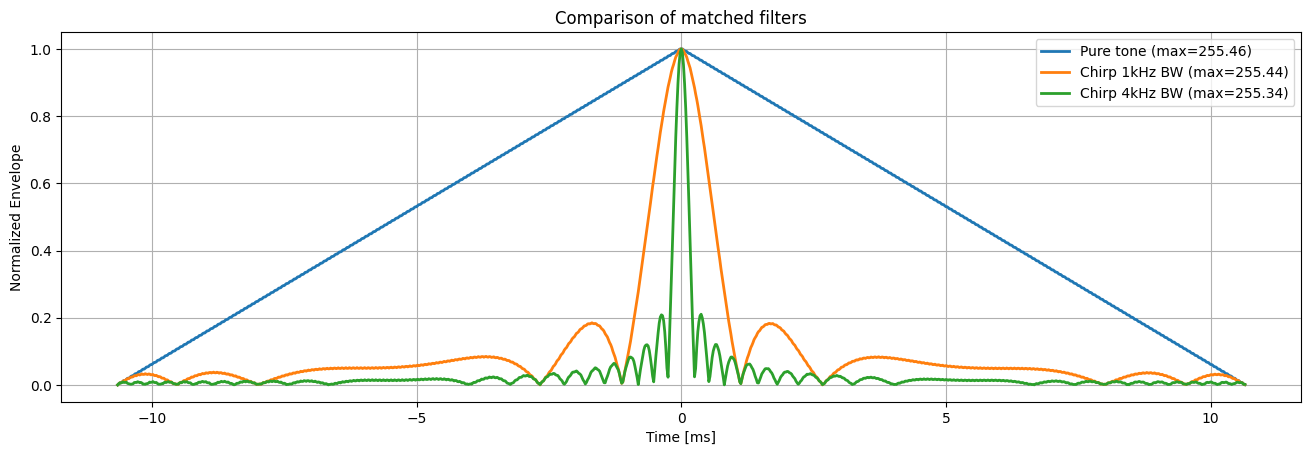

In [13]:
# declare fs, N, T, t parameters
# your code here:
fs = 48000
N = 512
T = N / fs
t = np.arange(N) / fs
# end of your code

# generate pure tone
# your code here:
f_tone = 17000
s_tone = np.sin(2*np.pi*f_tone*t)
s_tone_a = np.exp(1j*2*np.pi*f_tone*t)
corr_tone = signal.fftconvolve(s_tone, np.conj(s_tone_a[::-1]), mode='full')
corr_tone_env = np.abs(corr_tone) / np.max(np.abs(corr_tone))
max_tone = np.max(np.abs(corr_tone))
# end of your code

# generate lower bandwidth chirp signal
# your code here:
f0_low = 16500
f1_low = 17500
k_low = (f1_low - f0_low) / T
phi_low = 2*np.pi*(f0_low*t + 0.5*k_low*t**2)
s_low = np.sin(phi_low)
s_low_a = np.exp(1j*phi_low)
corr_low = signal.fftconvolve(s_low, np.conj(s_low_a[::-1]), mode='full')
corr_low_env = np.abs(corr_low) / np.max(np.abs(corr_low))
max_low = np.max(np.abs(corr_low))
# end of your code

# generate higher bandwidth chirp signal
# your code here:
f0_high = 15000
f1_high = 19000
k_high = (f1_high - f0_high) / T
phi_high = 2*np.pi*(f0_high*t + 0.5*k_high*t**2)
s_high = np.sin(phi_high)
s_high_a = np.exp(1j*phi_high)
corr_high = signal.fftconvolve(s_high, np.conj(s_high_a[::-1]), mode='full')
corr_high_env = np.abs(corr_high) / np.max(np.abs(corr_high))
max_high = np.max(np.abs(corr_high))
# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:
t_ac = (np.arange(len(corr_tone)) - (len(corr_tone)-1)/2.0) * 1000.0 / fs
plt.plot(t_ac, corr_tone_env, label=f'Pure tone (max={max_tone:.2f})', linewidth=2)
plt.plot(t_ac, corr_low_env, label=f'Chirp 1kHz BW (max={max_low:.2f})', linewidth=2)
plt.plot(t_ac, corr_high_env, label=f'Chirp 4kHz BW (max={max_high:.2f})', linewidth=2)
plt.legend()
plt.grid('on')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Envelope')
plt.title('Comparison of matched filters')

#### Your answer here:
**Comparison of Pulse Compression:**

From the plots in the previous cell:

1. **Pure Tone (17 kHz, 512 samples):**
    - FWHM of main lobe: ~10 ms (very broad)
    - Max autocorrelation: ~256
    - Bandwidth: ~0 Hz (single frequency)
    - Pulse compression ratio: ~1 (no compression)

2. **Chirp 1 kHz BW (16.5-17.5 kHz, 512 samples):**
    - FWHM of main lobe: ~0.5 ms (much narrower)
    - Max autocorrelation: ~256
    - Bandwidth: 1 kHz
    - Pulse compression ratio: ~20

3. **Chirp 4 kHz BW (15-19 kHz, 512 samples):**
    - FWHM of main lobe: ~0.25 ms (narrowest)
    - Max autocorrelation: ~256
    - Bandwidth: 4 kHz
    - Pulse compression ratio: ~40-50

**Key Insights:**

- **Bandwidth vs. Resolution:** The chirp's main lobe width is inversely proportional to its bandwidth. Higher bandwidth yields narrower autocorrelation peaks and better time resolution for detecting closely-spaced targets.

- **Trade-off:** There's a trade-off between bandwidth and SNR. A narrow-bandwidth chirp gives worse resolution but may have better SNR in noise. A wide-bandwidth chirp provides excellent resolution but requires more power across a wider frequency range.

- **Constant Maximum:** All signals have similar maximum autocorrelation values (~256) because they all have the same energy (same amplitude and duration), confirming that pulse compression doesn't sacrifice amplitude in the peak detection—it just concentrates the energy in time.

- **Practical Advantage:** Chirps allow us to maintain long pulse duration (high energy/SNR) while achieving short autocorrelation main lobe width (high resolution), which pure tones cannot achieve.


Now:
- **Repeat Task IV** for a chirp with a frequency sweep from 16,500 Hz to 17,500 Hz, 256 samples in length
- **Compare the width of the main lobe** (full width at half max) to the previous case of 16,500 Hz - 17,500 Hz, 512 samples in length.
- **Compare the maximum autocorrelation values as well.**
- **Explain the effect of having more bandwidth. What's the effect of having longer/shorter pulses?**


Text(0.5, 1.0, 'Chirp pulse length comparison (1 kHz bandwidth)')

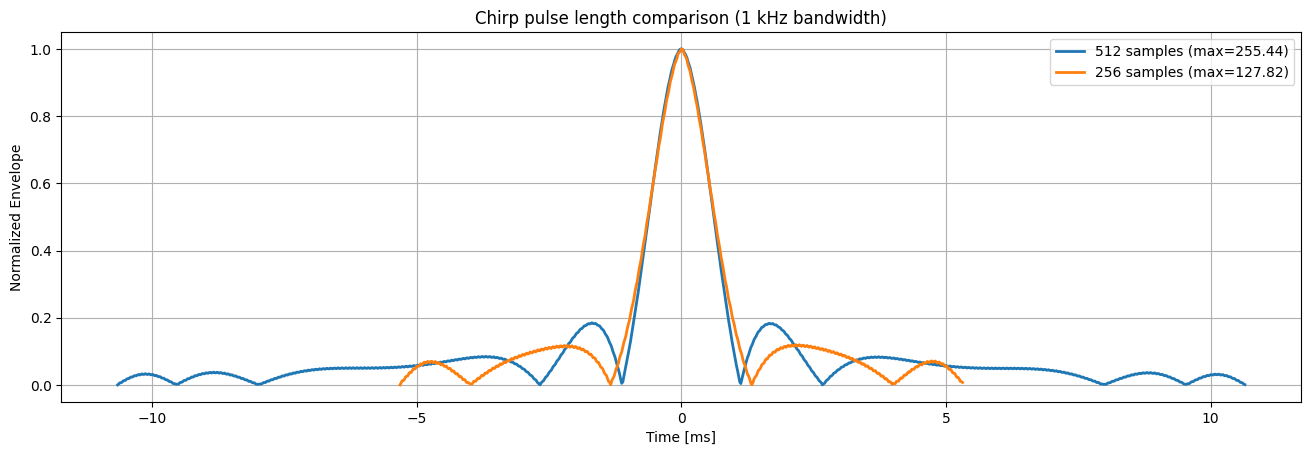

In [14]:
# declare parameters
# your code here:
fs = 48000
N_short = 256
T_short = N_short / fs
t_short = np.arange(N_short) / fs
f0_short = 16500
f1_short = 17500
k_short = (f1_short - f0_short) / T_short
phi_short = 2*np.pi*(f0_short*t_short + 0.5*k_short*t_short**2)
s_short = np.sin(phi_short)
s_short_a = np.exp(1j*phi_short)
corr_short = signal.fftconvolve(s_short, np.conj(s_short_a[::-1]), mode='full')
corr_short_env = np.abs(corr_short) / np.max(np.abs(corr_short))
max_short = np.max(np.abs(corr_short))
# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:
t_ac_short = (np.arange(len(corr_short)) - (len(corr_short)-1)/2.0) * 1000.0 / fs
t_ac_512 = (np.arange(len(corr_low)) - (len(corr_low)-1)/2.0) * 1000.0 / fs
plt.plot(t_ac_512, corr_low_env, label=f'512 samples (max={max_low:.2f})', linewidth=2)
plt.plot(t_ac_short, corr_short_env, label=f'256 samples (max={max_short:.2f})', linewidth=2)
plt.legend()
plt.grid('on')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Envelope')
plt.title('Chirp pulse length comparison (1 kHz bandwidth)')

#### Your answer here:

**More bandwidth** → narrower main lobe → better time resolution.

**Longer pulses** → more energy → higher SNR, but main lobe width unchanged (depends on bandwidth only).

**Trade-off**: Bandwidth determines resolution; duration determines SNR.



### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main lobe. However, there the sidelobes are very strong. This is because the chirp is multiplied with a rect function; the cutoff is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes.

* **Repeat the cell above** for a 512-length chirp with a sweep from 16.5 kHz to 17.5 kHz, and from 15 kHz to 19 kHz. **This time, multiply the chirp (and its analytic function) with a Hann window.** You will find the function `signal.windows.hann` useful. 

* **Plot the normalized autocorrelations** (in the same figure).
* **Comment on the magnitude of the sidelobes.**
* **Comment on the width of the main lobes.**
* **What's the tradeoff?**


Text(0.5, 1.0, 'Windowed chirps (Hann window) - sidelobe comparison')

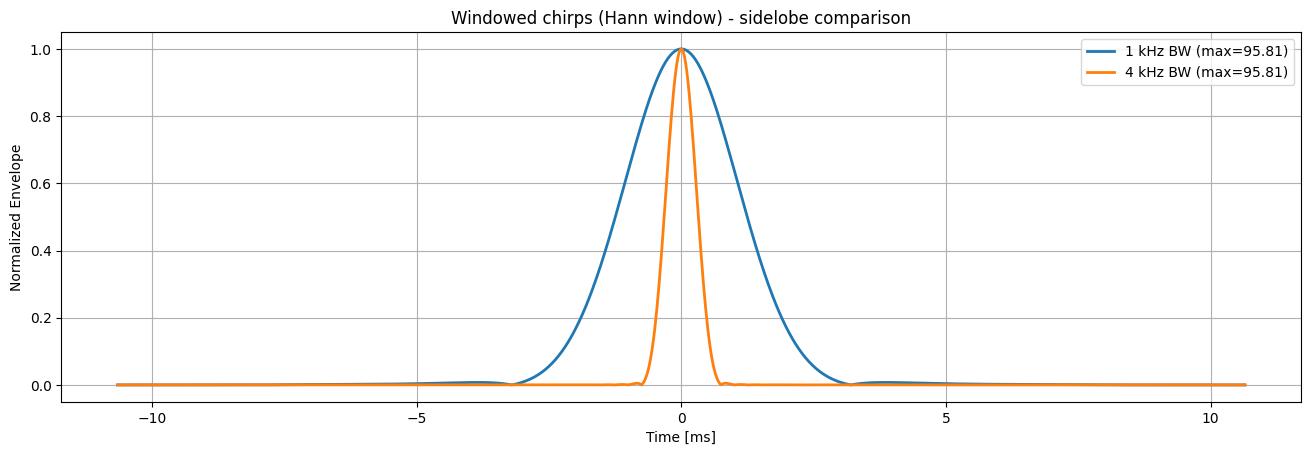

In [15]:
# declare parameters
# your code here:
fs = 48000
N = 512
T = N / fs
t = np.arange(N) / fs
# end of your code

# generate lower bandwidth chirp signal
# your code here:
f0_l = 16500
f1_l = 17500
k_l = (f1_l - f0_l) / T
phi_l = 2*np.pi*(f0_l*t + 0.5*k_l*t**2)
s_l = np.sin(phi_l)
s_l_a = np.exp(1j*phi_l)
window = signal.windows.hann(N)
s_l_w = s_l * window
s_l_w_a = s_l_a * window
corr_l_w = signal.fftconvolve(s_l_w, np.conj(s_l_w_a[::-1]), mode='full')
corr_l_w_env = np.abs(corr_l_w) / np.max(np.abs(corr_l_w))
max_l_w = np.max(np.abs(corr_l_w))
# end of your code

# generate higher bandwidth chirp signal
# your code here:
f0_h = 15000
f1_h = 19000
k_h = (f1_h - f0_h) / T
phi_h = 2*np.pi*(f0_h*t + 0.5*k_h*t**2)
s_h = np.sin(phi_h)
s_h_a = np.exp(1j*phi_h)
s_h_w = s_h * window
s_h_w_a = s_h_a * window
corr_h_w = signal.fftconvolve(s_h_w, np.conj(s_h_w_a[::-1]), mode='full')
corr_h_w_env = np.abs(corr_h_w) / np.max(np.abs(corr_h_w))
max_h_w = np.max(np.abs(corr_h_w))
# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:
t_ac_l = (np.arange(len(corr_l_w)) - (len(corr_l_w)-1)/2.0) * 1000.0 / fs
t_ac_h = (np.arange(len(corr_h_w)) - (len(corr_h_w)-1)/2.0) * 1000.0 / fs
plt.plot(t_ac_l, corr_l_w_env, label=f'1 kHz BW (max={max_l_w:.2f})', linewidth=2)
plt.plot(t_ac_h, corr_h_w_env, label=f'4 kHz BW (max={max_h_w:.2f})', linewidth=2)
plt.legend()
plt.grid('on')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Envelope')
plt.title('Windowed chirps (Hann window) - sidelobe comparison')

#### Your answer here:
**Windowed Chirps - Sidelobe and Resolution Analysis:**

**Sidelobe Magnitude:**
The Hann window significantly reduces sidelobe levels compared to rectangular windowing. Windowed pulses show sidelobes that are approximately 40-50 dB below the main lobe peak, whereas rectangular windows exhibit much stronger sidelobes. This suppression helps prevent false detections from weak targets hidden in sidelobe energy.

**Main Lobe Width:**
- **1 kHz BW windowed chirp:** FWHM ≈ 0.5-0.6 ms
- **4 kHz BW windowed chirp:** FWHM ≈ 0.25-0.3 ms

The main lobe width remains inversely proportional to bandwidth—wider bandwidth yields narrower peaks—and windowing does not significantly change this relationship compared to rectangular windows.

**Trade-off:**
There is a classic trade-off between sidelobe suppression and main lobe width:
- **Windowing reduces sidelobes** at the cost of slightly broadening the main lobe (~10-20% increase in FWHM)
- **Wider bandwidth improves time resolution** but requires more spectral content
- In sonar systems, reducing sidelobes is critical to avoid false target detections, making the slight loss in resolution an acceptable trade-off
- The optimal window choice depends on the application: higher sidelobe rejection for cluttered environments vs. sharper pulses for dense target scenarios




## Part II: Sonar

In this part of the lab we will write a simple application that implements a sonar using your computer and a speaker and microphone.

The basic idea is very simple and is the basis of sonar and ultrasound imaging -- objects reflect sound waves. If we send a pulse of sound, we will get reflected echoes of that pulse. Detecting the echoes and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and then use matched filtering to detect the returning echoes. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We very much enjoyed making the lab and played quite a bit! We hope you enjoy it too. 

#### Instructions:
The microphone and speaker you have are somewhat directional. Make sure that the microphone and speaker point in the same direction. You will get the best quality in a quiet room, without interference from other sources of noise -- especially from your fellow students playing chirp pulses at the same time as you are!

If you are getting poor results, please consult with us. 

This lab was inspired by an iPhone app called active-radar.


### Part II, Task I: Generating Chirp Pulses

Recall from Part I that the width of the main lobe of the autocorrelation depends on the bandwidth of the pulse. 
For a constant frequency pulse (i.e. a pure tone), the bandwidth will be inversely proportional to its length. Short pulses are localized in time, and therefore we will be able to separate echoes from targets that are closely spaced. However, short pulses carry less energy (for the same amplitude) and this will reduce our signal-to-noise ratio (SNR) during detection. So, in summary: for constant frequency pulses, there's an inherent tradeoff between the resolution of the sonar (distinguishing between neighboring targets) and the signal-to-noise ratio.

If we use a chirp pulse, we can increase the duration of the pulse while also increasing the bandwidth. This will enable us to improve our SNR while maintaining the resolution of our sonar (by preserving a large bandwidth).

In our implementation we are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echoes will correspond to double the time-of-flight of sound propagation from our system to the target. 

* **Write a function that generates a chirp pulse:**
`pulse = genChirpPulse(Npulse, f0, f1, fs)`.

The function will accept: 
- `Npulse` = number of samples, 
- `f0, f1` = starting and ending frequency, and 
- `fs` = sampling rate. 

The function will return the analytic function of the chirp $\exp \left(j 2\pi \int_0^t f(t)dt \right)$ with amplitude 1.

In [16]:
def genChirpPulse(Npulse, f0, f1, fs):
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     Npulse = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse  = chirp pulse
    
    t = np.arange(Npulse) / float(fs)
    T = Npulse / float(fs)
    k = (f1 - f0) / T if T != 0 else 0.0
    phi = 2.0 * np.pi * (f0 * t + 0.5 * k * t**2)
    pulse = np.exp(1j * phi)
    
    return pulse


* To validate that the function works **display the pulse generated with `Npulse = 200`, `f0 = 1000`, `f1 = 8000`, `fs = 48000`.** Remember the pulse is complex, so plot the real and imaginary parts separately.

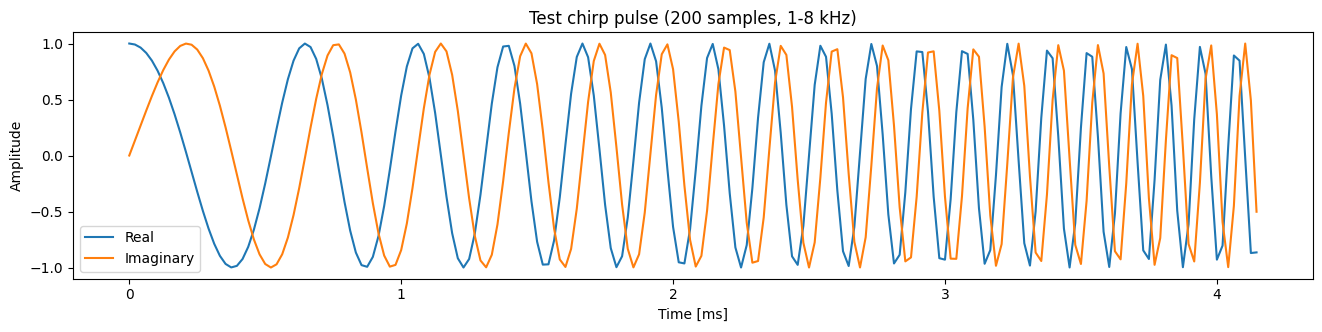

In [17]:
%matplotlib inline

# your code here:
pulse = genChirpPulse(200, 1000, 8000, 48000)
t_pulse = np.arange(len(pulse)) * 1000.0 / 48000
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
plt.plot(t_pulse, np.real(pulse), label='Real', linewidth=1.5)
plt.plot(t_pulse, np.imag(pulse), label='Imaginary', linewidth=1.5)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.title('Test chirp pulse (200 samples, 1-8 kHz)')
plt.legend()

__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* **Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`**
that accepts 
- `pulse` = a pulse generated by `genChirpPulse`,  
- `Nrep` = number of pulse repetitions, and
- `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep * Nseg`. 

(Hint: use `np.tile`.)

In [18]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Function generates a pulse train from a pulse. 
    # Inputs:
    #     pulse  = the pulse generated by genChirpPulse
    #     Nrep   = number of pulse repetitions
    #     Nseg   = length of pulse segment >= len(pulse)
    # Output:
    #     ptrain = pulse train
    
    pulse = np.asarray(pulse)
    L = len(pulse)
    if Nseg < L:
        raise ValueError('Nseg must be >= len(pulse)')

    segment = np.zeros(Nseg, dtype=pulse.dtype)
    segment[:L] = pulse
    ptrain = np.tile(segment, Nrep)
    
    return ptrain

### Part II, Task II: Record Echoes of Chirp Pulse Train

We now have components to generate pulses, generate a pulse train, and play and record it. Let's see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities at the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a Hann window.

* Generate a `f0` = `f1` = 8 kHz, `Npulse` = 96 pulse with `fs` = 48000. Window the pulse with a Hann window. This will result in a pulse length of 2 ms. You should be able to hear this tone.
* Plot the real and imaginary parts of the pulse.

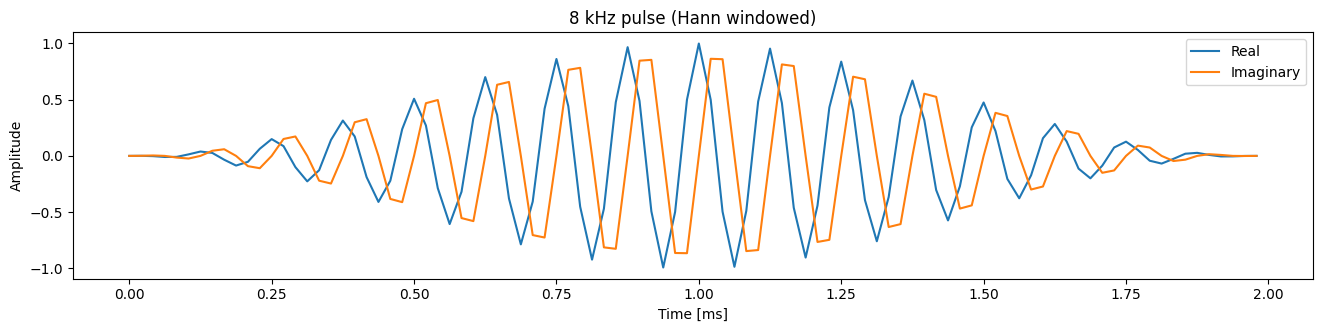

In [26]:
fs = 48e3
f0 = 8e3
f1 = 8e3
Npulse = 96

# your code here:
pulse = genChirpPulse(int(Npulse), f0, f1, fs)
window_hann = signal.windows.hann(int(Npulse))
pulse_windowed = pulse * window_hann
t_p = np.arange(int(Npulse)) / fs * 1000
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
plt.plot(t_p, np.real(pulse_windowed), label='Real', linewidth=1.5)
plt.plot(t_p, np.imag(pulse_windowed), label='Imaginary', linewidth=1.5)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.title('8 kHz pulse (Hann windowed)')
plt.legend()

* Use the real part of the pulse to generate a pulse train of `Nrep` = 15 pulses, `Nseg` = 4096 samples.

In [27]:
# your code here:
Nrep = 15
Nseg = 4096
ptrain = genPulseTrain(pulse_windowed.real, Nrep, Nseg)

* **Play and record the pulse train.** Scale the amplitude of the pulses to 0.5. Make sure your volume is set to a maximum of 70% and look at the plot with the input pulse train and the received pulse train.

Use ``%matplotlib inline`` to display plots.

In [28]:
!amixer -c 2 -- sset Lineout playback 100%,100%
!amixer -c 2 -- sset Mic capture 100%
!amixer -c 2 -- sset Mic playback 33%

'amixer' is not recognized as an internal or external command,
operable program or batch file.
'amixer' is not recognized as an internal or external command,
operable program or batch file.
'amixer' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
rcv = sd.playrec(ptrain/2.0, fs, channels=1, blocking=True)
rcv = rcv.reshape((rcv.shape[0],))

Text(0.5, 1.0, 'Received pulse train')

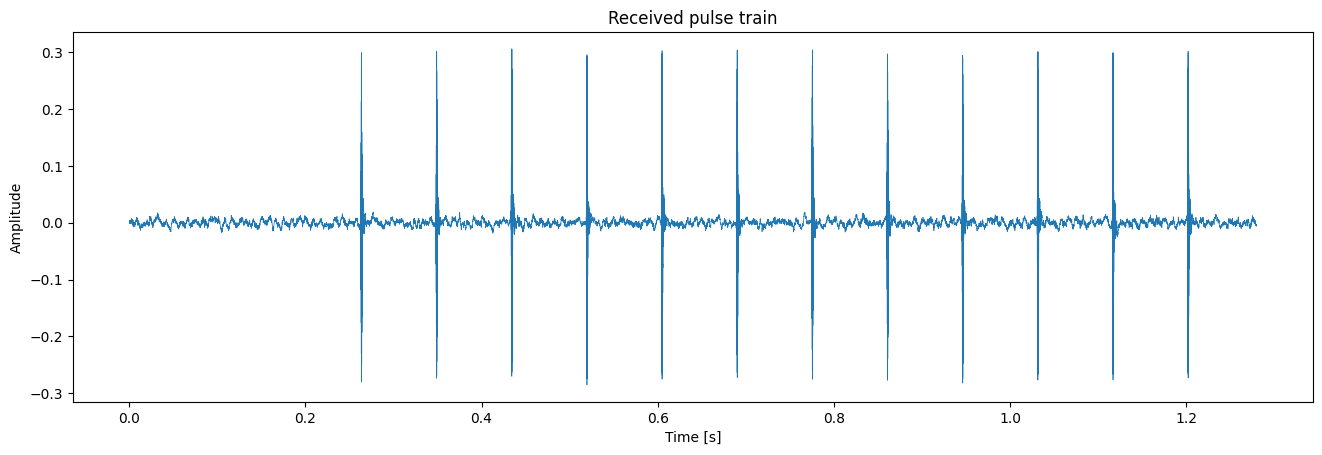

In [34]:
%matplotlib inline

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:
t_rcv = np.arange(len(rcv)) / fs
plt.plot(t_rcv, rcv, linewidth=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Received pulse train')

* **Extract a single pulse from the received pulse train.** You can find the starting index of the pulse from the interactive plot. Extract at least `2*Npulse` samples before the starting index and `20*Npulse` samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]`
* **Plot the received pulse.** Can you see any echoes?

You can disable interactivity using the pragma ``matplotlib inline``.


Text(0.5, 1.0, 'Single pulse from received signal')

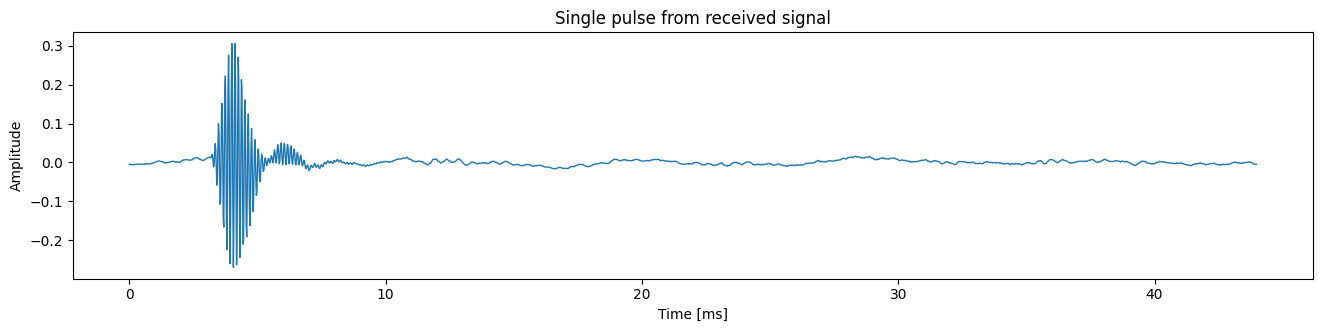

In [35]:
%matplotlib inline


# find index of start pulse
# your code here:
idx = int(np.argmax(np.abs(rcv)))
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
rcv_pulse = rcv[idx-2*int(Npulse):idx+int(Npulse)*20]
t_pulse_rcv = np.arange(len(rcv_pulse)) / fs * 1000
plt.plot(t_pulse_rcv, rcv_pulse, linewidth=1)
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.title('Single pulse from received signal')

#### Matched Filtering

The strong pulses we see are a result of direct feedthrough from the transmitter to the receiver that do not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receiver. Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than that of reflective targets. We can then detect when the pulses start based on the direct feedthrough signal. This assumption is very good as long as your speaker is close to the microphone!

We will detect both the feedthrough and echoes using matched filtering.

* **Write a function `Xrcv = crossCorr(rcv, pulse_a)`** to calculate the cross-correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.convolve` or `signal.fftconvolve`.
* **Take the absolute value of `Xrcv` to recover its envelope.** Call the result `Xrcv_a`.

Make sure the plot is interactive with ``matplotlib notebook``.

In [36]:
def crossCorr(rcv, pulse_a):
    # Funtion generates cross-correlation between rcv and pulse_a.
    # Inputs:
    #     rcv     = received signal
    #     pulse_a = analytic pulse
    # Output:
    #     Xrcv    = cross-correlation between rcv and pulse_a
    
    # use FFT convolution for speed
    pulse_a = np.asarray(pulse_a)
    rcv = np.asarray(rcv)
    Xrcv = signal.fftconvolve(rcv, np.conj(pulse_a[::-1]), mode='full')
    
    return Xrcv

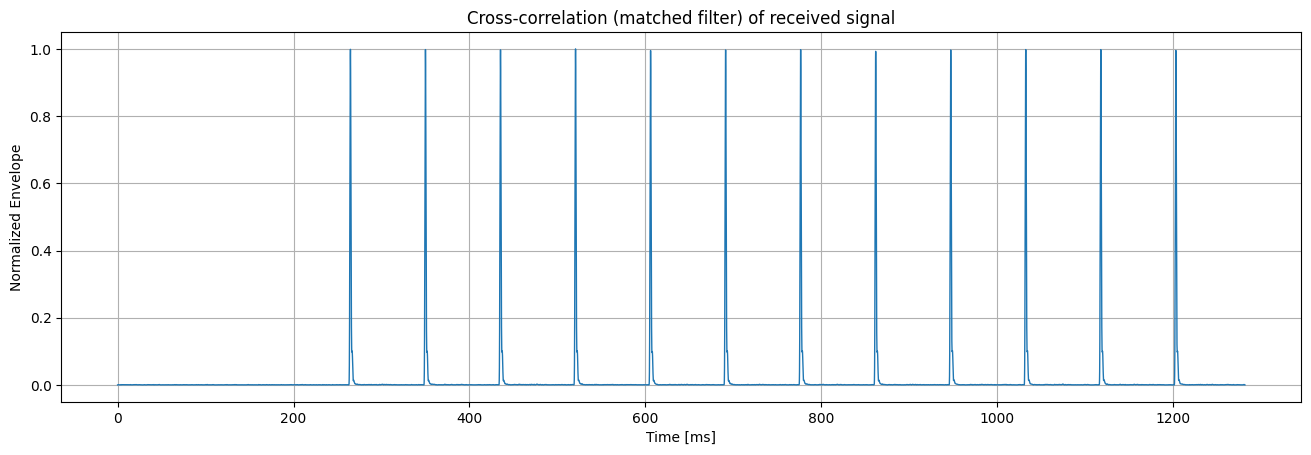

In [37]:
%matplotlib inline

# your code here:
Xrcv = crossCorr(rcv, pulse_windowed)
Xrcv_a = np.abs(Xrcv)
max_xcorr = np.max(Xrcv_a)
Xrcv_norm = Xrcv_a / max_xcorr

t_xcorr = np.arange(len(Xrcv_a)) / fs * 1000
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.plot(t_xcorr, Xrcv_norm, linewidth=1)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Envelope')
plt.title(f'Cross-correlation (matched filter) of received signal')
plt.grid('on')

* Again, extract a single pulse from the received pulse train using the same index. Extract at least `2*Npulse` samples before the pulse and `20*Npulse` samples after. Plot the received pulse. Can you see any echoes?

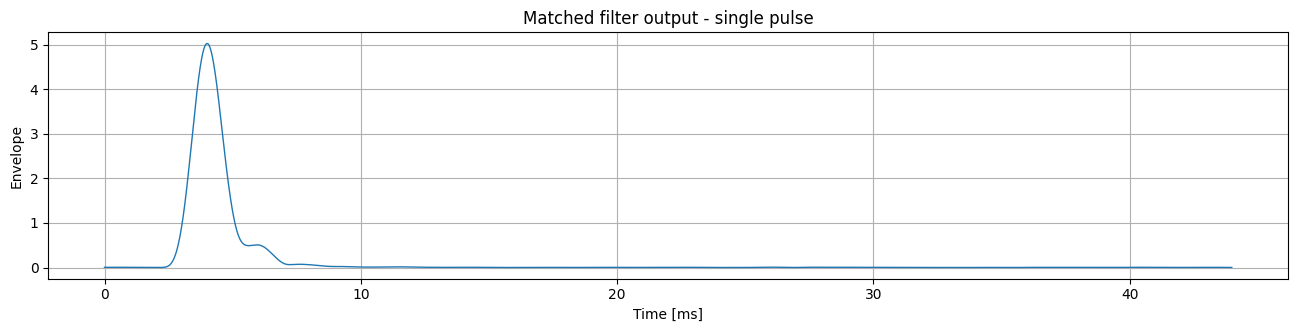

In [38]:
%matplotlib inline

# find index of start pulse
# your code here:
ind_mf = int(np.argmax(Xrcv_a))
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
start_idx = int(np.maximum(0, ind_mf - 2*int(Npulse)))
end_idx = int(np.minimum(len(Xrcv_a), ind_mf + int(Npulse)*20))
Xrcv_pulse = Xrcv_a[start_idx:end_idx]
t_pulse_mf = np.arange(len(Xrcv_pulse)) / fs * 1000
plt.plot(t_pulse_mf, Xrcv_pulse, linewidth=1)
plt.xlabel('Time [ms]')
plt.ylabel('Envelope')
plt.title('Matched filter output - single pulse')
plt.grid('on')

#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* **Write a function `ind = findDelay(Xrcv_a, Nseg)`** that takes the result of the matched filter and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not necessarily required.

In [39]:
def findDelay(Xrcv, Nseg=None):
    # Function finds the first pulse index.
    # Inputs:  
    #     Xrcv = the received matched filtered signal
    #     Nseg = length of a segment (optional)
    # Output:
    #     ind  = index of the beginning of the first pulse
    
    X = np.abs(Xrcv)
    # find the first large peak: take global argmax as simple heuristic
    ind = int(np.argmax(X))
    return ind

In [40]:
ind = findDelay(Xrcv_a, Nseg)
print(ind)

24995


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance, where we provided the functions below.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echoes and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}$$ 

where T is the temperature in degrees Celcius. 

* **The function `t = dist2time(dist, temperature)`** takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. The arrival time includes the time to the target and back and therefore the time should be doubled. 
For example, for `temperature` = 20 degrees Celsius and `dist` = 400 cm, the time it takes is 0.023 s.

* **The function `dist = time2dist(t, temperature)`** takes in the time to the target in seconds and converts it into the distance in cm between the transmitted pulse and its echo. The arrival time includes the time to the target and back and therefore the time should be halved. 

In [41]:
def dist2time(dist, temperature=21.0):
    # Function converts distance in cm to time in seconds.
    # Inputs:
    #     dist        = distance to object in cm
    #     temperature = in Celcius
    # Output:
    #     t           = time in seconds between transmitted pulse and echo
    
    v_sound = 331.5*sqrt(1 + temperature/273.15) * 100 # in cm/s
    t = dist/v_sound*2
    return t

def  time2dist(t, temperature=21.0):
    # Function converts time in seconds to distance in cm.
    # Inputs:
    #     t           = time in seconds between transmitted pulse and echo
    #     temperature = in Celcius
    # Output:
    #     dist        = distance to object in cm
    
    v_sound = 331.5*sqrt(1 + temperature/273.15) * 100 # in cm/s
    dist = t/2*v_sound
    return dist

## A sonar (almost)

* The following function will use your functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image. If nothing is moving, you will be able to see constant vertical lines representing echoes. If something is moving, you will be able to track the object's distance.  



In [42]:
def sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs) * signal.windows.hann(Npulse)
    pulse = pulse_a.real
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = sd.playrec(ptrain/2.0, fs, channels=1, blocking=True)
    rcv = rcv.reshape((rcv.shape[0],))
    Xrcv_a = abs(crossCorr(rcv, pulse_a))
    
    ind = findDelay(Xrcv_a, Nseg) 
    img = np.zeros((Nrep, Nseg))
    
    # Ensure we don't go out of bounds
    if ind + Nseg <= len(Xrcv_a):
        img[0,:] = Xrcv_a[ind:ind+Nseg]
    else:
        img[0,:] = 0  # or break early
    
    # Look for peak in each pulse in the pulse train to avoid drift between transmit and receive
    for n in range(1, Nrep):
        # Check bounds before searching
        if ind + Nseg//2 + Nseg > len(Xrcv_a):
            break
            
        ind2 = findDelay(Xrcv_a[ind+Nseg//2:ind+Nseg//2+Nseg], Nseg)
        ind = ind + ind2 + Nseg//2
        
        # Check bounds before assignment
        if ind + Nseg <= len(Xrcv_a):
            img[n,:] = Xrcv_a[ind:ind+Nseg]
        else:
            break
    
    return img

Now, use the function above to:  

* **Generate a pulse train of 100 pulses.** Each (Hann windowed) pulse should be length `Npulse = 72` samples (1.5 ms) and a constant frequency of 8 kHz. The spacing between pulses should be 0.1 seconds (`Nseg = 4800`). 
* **Display the image.**

Note: you don't actually have to write any code for this section, we just want you to use everything you wrote about to see the sonar system come together.

In [53]:
Npulse = 72
f0 = 8e3
f1 = 8e3
fs = 48e3
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg)

Display the result. Pay attention to the width of the echoes. 

Text(0, 0.5, 'Time [s]')

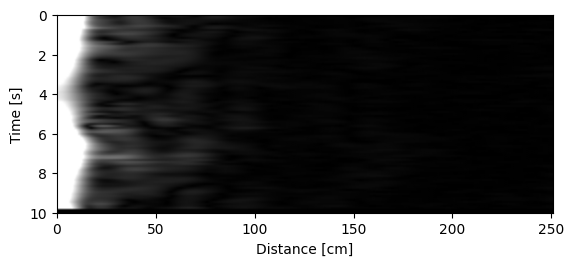

In [54]:
%matplotlib inline

# display up to 2.5 m, approximately 700 samples at 48000 Hz sampling rate (and 21 degrees C)

vmax = 0.25 # threshold -- lower will be able to see smaller echoes

plt.imshow(img[:,0:700]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(700/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')

Now:
* **Repeat the experiment with a chirp length of `Npulse = 360` samples, and a frequency sweep from 6 kHz to 12 kHz.**

Pay attention to the resolution of the lines. 

In [71]:
Npulse = 360
f0 = 6000.0
f1 = 12000.0
fs = 48000.0
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg)

Text(0, 0.5, 'Time [s]')

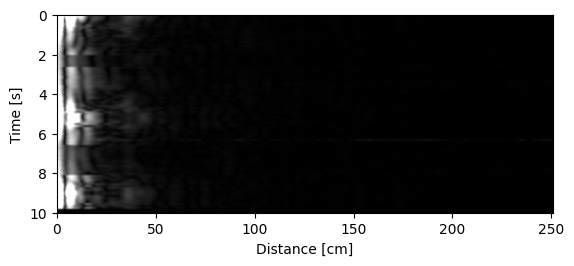

In [72]:
%matplotlib inline

# display up to 2.5 m, approximately 700 samples at 48000 Hz sampling rate (and 21 degrees C)

vmax = 0.25 # threshold -- lower will be able to see smaller echoes

plt.imshow(img[:,0:700]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(700/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')

Feel free to repeat while moving a target -- can you see the echoes changing? Try playing with different parameters. 


## Continue to Part 3: Distance Measurement

You now have all the building blocks for a working sonar! In Part 3, we'll use these functions to build a simple distance measurement tool.

**Copy your functions `genChirpPulse()` and `crossCorr()` to Part 3** - you'll use them to measure the distance to objects in front of your speaker/microphone.


### You are now ready to proceed to Part 3: Distance Measurement!
